In [1]:
# imports
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
import torch.optim as optim
import matplotlib.pyplot as plt

In [2]:
# for reuseability
torch.manual_seed(42)

In [3]:
# checking for gpu
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'using device: {device}')

using device: cuda


In [5]:
df=pd.read_csv('/kaggle/input/fashionmnist/fashion-mnist_train.csv')
df.sample(5)

,label,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783,pixel784
3435,8,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
693,2,0,0,0,0,0,0,0,0,0,...,0,0,0,106,157,64,0,0,0,0
8431,3,0,0,0,0,0,0,0,0,0,...,138,87,67,0,0,0,0,0,0,0
35695,0,0,0,0,0,0,0,0,0,0,...,126,160,61,0,1,0,0,0,0,0
42865,6,0,0,0,0,0,0,0,6,0,...,0,0,0,0,0,0,0,0,0,0


In [6]:
df.shape

(60000, 785)

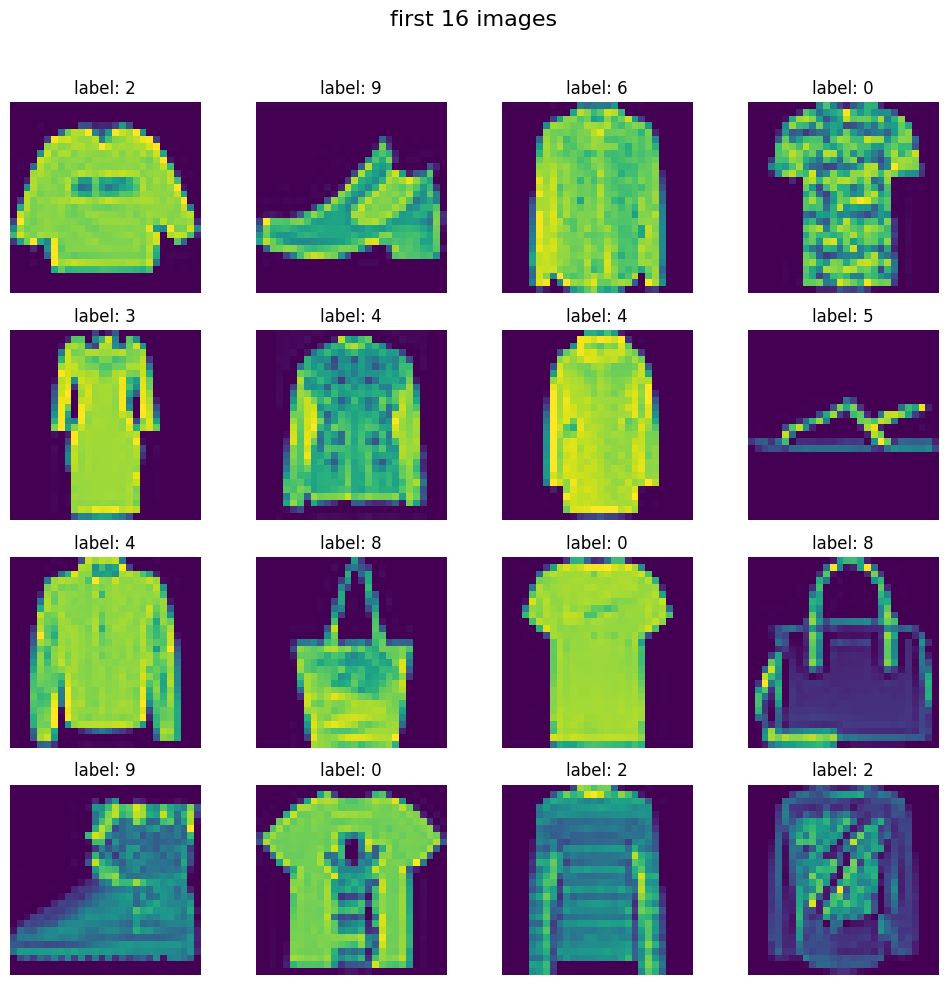

In [7]:
# Create a 4x4 grid of images
fig,axes=plt.subplots(4,4,figsize=(10,10))
fig.suptitle('first 16 images',fontsize=16)

# plot images
for i,ax in enumerate(axes.flat):
    img=df.iloc[i,1:].values.reshape(28,28)
    ax.imshow(img)
    ax.axis('off')
    ax.set_title(f'label: {df.iloc[i,0]}')
    
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

In [8]:
X = df.iloc[:, 1:].values
y = df.iloc[:, 0].values

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [10]:
X_train = X_train/255.0
X_test = X_test/255.0

In [11]:
class CustomDataset(Dataset):
    def __init__(self,features,labels):
        self.features=torch.tensor(features,dtype=torch.float32)
        self.labels=torch.tensor(labels,dtype=torch.long)

    def __len__(self):
        return len(self.features)

    def __getitem__(self,index):
        return self.features[index],self.labels[index]

In [12]:
train_dataset=CustomDataset(X_train, y_train)
test_dataset = CustomDataset(X_test, y_test)

In [13]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, pin_memory=True)

In [14]:
len(train_loader)

750

# Dropout and Batch Normalization

In [15]:
class MyNN(nn.Module):
    def __init__(self,num_features):
        super().__init__()
        self.model=nn.Sequential(
            nn.Linear(num_features,128),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(128,64),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(p=0.3),
            nn.Linear(64,10)
        )

    def forward(self,x):
        return self.model(x)

In [16]:
learning_rate = 0.1
epochs = 100

# Regularisation

In [17]:
# instatiate the model
model = MyNN(X_train.shape[1])
model = model.to(device)
# loss function
criterion = nn.CrossEntropyLoss()
# optimizer
optimizer = optim.SGD(model.parameters(), lr=learning_rate,weight_decay=1e-4)

In [18]:
# training loop

for epoch in range(epochs):

  total_epoch_loss = 0

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    # forward pass
    outputs = model(batch_features)

    # calculate loss
    loss = criterion(outputs, batch_labels)

    # back pass
    optimizer.zero_grad()
    loss.backward()

    # update grads
    optimizer.step()

    total_epoch_loss = total_epoch_loss + loss.item()

  avg_loss = total_epoch_loss/len(train_loader)
  print(f'Epoch: {epoch + 1} , Loss: {avg_loss}')

Epoch: 1 , Loss: 0.6222693039973577
Epoch: 2 , Loss: 0.47966872131824495
Epoch: 3 , Loss: 0.44517430343230563
Epoch: 4 , Loss: 0.4187118261853854
Epoch: 5 , Loss: 0.40011794965465863
Epoch: 6 , Loss: 0.38877922976017
Epoch: 7 , Loss: 0.37223929331700006
Epoch: 8 , Loss: 0.36345352375507356
Epoch: 9 , Loss: 0.3545418153305848
Epoch: 10 , Loss: 0.3474548334479332
Epoch: 11 , Loss: 0.33704903252919516
Epoch: 12 , Loss: 0.33471197565396626
Epoch: 13 , Loss: 0.33131099833051364
Epoch: 14 , Loss: 0.32008534063895544
Epoch: 15 , Loss: 0.3137275479535262
Epoch: 16 , Loss: 0.3117637587785721
Epoch: 17 , Loss: 0.31089310092727346
Epoch: 18 , Loss: 0.30427425000071523
Epoch: 19 , Loss: 0.30145924965540566
Epoch: 20 , Loss: 0.2960521096785863
Epoch: 21 , Loss: 0.29235353526473046
Epoch: 22 , Loss: 0.29426025275389356
Epoch: 23 , Loss: 0.29011708369851114
Epoch: 24 , Loss: 0.28720206103722257
Epoch: 25 , Loss: 0.283035126209259
Epoch: 26 , Loss: 0.2765031195580959
Epoch: 27 , Loss: 0.27652540395657

In [19]:
model.eval()

MyNN(
  (model): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
    (4): Linear(in_features=128, out_features=64, bias=True)
    (5): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): ReLU()
    (7): Dropout(p=0.3, inplace=False)
    (8): Linear(in_features=64, out_features=10, bias=True)
  )
)

In [20]:
# evaluation code in train data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in train_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)

0.9473333333333334


In [21]:
# evaluation code in test data
total = 0
correct = 0

with torch.no_grad():

  for batch_features, batch_labels in test_loader:

    # move data to gpu
    batch_features, batch_labels = batch_features.to(device), batch_labels.to(device)

    outputs = model(batch_features)

    _, predicted = torch.max(outputs, 1)

    total = total + batch_labels.shape[0]

    correct = correct + (predicted == batch_labels).sum().item()

print(correct/total)


0.88425
